In [3]:
#!pip3 install --user astropy

In [4]:
import numpy as np
import astropy as ap
from astropy.io import fits
import scipy.linalg as slg
import glob
import os

In [66]:
run_path = "/home/portmanm/run2_1000_galfit"
sparc_in = "sparcfire-in"
sparc_out = "sparcfire-out"
sparc_tmp = "sparcfire-tmp"
galfits_tmp = "galfits"
galfit_out = "all_galfit_out"

In [158]:
def check_galfit_chi(gal_name, base_path):
    # An example line
    # # Chi^2/nu = 4.661,  Chi^2 = 12025.575,  Ndof = 2580
    
    galfit_txt_out = "galfit.01" # in the future galfit.01 may change
    filename = os.path.join(base_path, gal_name, galfit_txt_out)
    with open(filename, "r") as f:
        for line in f:
            if "Chi" in line:
                chi_line = line.strip("# ")
    
    # This also works but it's quite devious..
    # chi_line.replace("^", "").replace("/", "_").replace(",  ", "\n").lower()
    # exec(chi_line)
    
    out_vals = chi_line.split(",")
    chi2_nu = float(out_vals[0].strip().split("=")[-1])
    chi2 = float(out_vals[1].strip().split("=")[-1])
    ndof = int(out_vals[2].strip().split("=")[-1])
    
    return chi2_nu, chi2, ndof

In [236]:
norms = {}
total_gal = len(glob.glob(os.path.join(run_path, sparc_in, "*.fits")))
outpath = os.path.join(run_path, sparc_out)#, galfit_out)
temppath = os.path.join(run_path, sparc_tmp, galfits_tmp)
#successes = [os.path.basename(i) for i in glob.glob(os.path.join(temppath, "*.fits"))]

for i in glob.glob(os.path.join(temppath, "*.fits")):
    fits_file = fits.open(i)
    filename = os.path.basename(i)
    galaxy_name = filename.split("_")[0]
    
    try:
        norms[filename] = *check_galfit_chi(galaxy_name, outpath)[:2], slg.norm(fits_file[3].data)
    # for infs, nans in residual
    except ValueError:
        pass
    fits_file.close()
#glob.glob("./" + galaxy_path + '/' + galaxy_name + '.tsv')[0]

In [237]:
norms = dict(sorted(norms.items(), key=lambda item: item[1][1]))
norm_items = list(norms.items())

In [192]:
#for i in sorted(norms.items(), key=lambda item: item[1][0]):
#    print(i)

In [71]:
#galaxy_name = "1237667429560025179"
#basepath = os.path.join(run_path, sparc_out)
#print(*check_galfit_chi(galaxy_name, basepath))
#print(norms[f"{galaxy_name}_out.fits"])

In [79]:
# count = 0
# for k,v in norms.items():
#     galaxy_name = k.split("_")[0]
#     print(*check_galfit_chi(galaxy_name, basepath)[:2])
#     print(v)
#     count += 1
#     if count == 10: break

In [210]:
#test_list = [f"{k} : chi^2/nu = {v[0]}, chi^2 = {v[1]}" for k,v in norms.items()] #if round(v) < 1000]
#test_list = [f"{k} : {v[1]}" for k,v in norms.items()] #if round(v) < 1000]
#test_list = [f"{k} -- {round(v)}" for k,v in norms.items() if round(v) < 1000]

In [238]:
count = 0
for i in norms.items():
    print(i)
    count += 1
    if count == 20:
        break
#print(test_list[-10:])

('1237668297666396292_out.fits', (0.043, 27.861, 383.7183))
('1237667911674691747_out.fits', (0.059, 29.404, 322.17413))
('1237671122687230244_out.fits', (0.059, 47.841, 625.4855))
('1237671992951177397_out.fits', (0.077, 48.499, 431.44357))
('1237671958590849176_out.fits', (0.06, 52.612, 471.4688))
('1237667442974982337_out.fits', (0.071, 53.361, 360.8795))
('1237667550881120426_out.fits', (0.08, 55.279, 316.9971))
('1237668349218390247_out.fits', (0.053, 55.682, 423.44662))
('1237667910602195087_out.fits', (0.071, 56.524, 450.3991))
('1237672793961136289_out.fits', (0.091, 59.325, 469.6679))
('1237668297680879849_out.fits', (0.115, 59.773, 485.7202))
('1237668589728366770_out.fits', (0.082, 60.409, 385.68643))
('1237667783367786721_out.fits', (0.087, 62.929, 380.19458))
('1237668271358869724_out.fits', (0.101, 64.428, 298.3397))
('1237667781760450640_out.fits', (0.102, 66.17, 576.85345))
('1237674371289383396_out.fits', (0.085, 69.305, 363.14066))
('1237667536391700628_out.fits', (0.

In [174]:
png_dir = os.path.join(run_path, sparc_out, galfit_out, "galfit_png/")

In [14]:
from IPython.display import Image

In [15]:
# Grab top 1000 highest resolution galaxies from Darren's 27K and run this on those
# Change pitch angle plotting to only plot sparcfire's line between r_in and r_out and see how that compare to galfit
# Tile residuals for presentation???

1237667910602522764_out.fits
chi^2/nu = 0.13
chi^2 = 71.54
residual = 28477.81


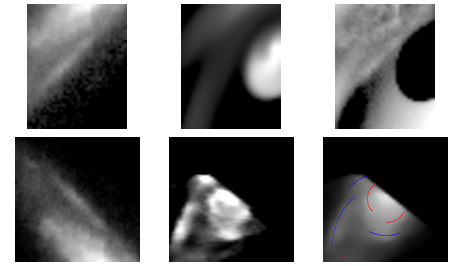

In [241]:
# https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o
index_num = 18
#galaxy_name = test_list[index_num].split("_")[0]
galaxy_info = norm_items[index_num]#.split(" : ")
#chi2_nu, chi2, ndof = check_galfit_chi(galaxy_name, outpath)
print(f"{galaxy_info[0]}")
print(f"chi^2/nu = {galaxy_info[1][0]:.2f}")
print(f"chi^2 = {galaxy_info[1][1]:.2f}")
print(f"residual = {galaxy_info[1][2]:.2f}")


out_str = galaxy_info[0].replace("out.fits", "combined.png").strip()
Image(filename = os.path.join(png_dir, out_str), width=600, height=600)

In [75]:
#print(len(test_list), len(norms), 717/809*100)
print(f"Total number of galaxies attempted: {total_gal}")
print(f"Number of Galfit models generated: {len(norms)}")
#print(f"Residuals below arbitrary cutoff: {len(test_list)}")
print()
#print(f"Percent models generated: {100*len(norms)/total_gal:.2f}%")
#print(f"Percent successful below cutoff excluding failures: {100*len(test_list)/len(norms):.2f}%")
#print(f"Percent successful below cutoff including failures: {100*len(test_list)/total_gal:.2f}%")

Total number of galaxies attempted: 1000
Number of Galfit models generated: 903

